
# HEAD


================================================================================

**PROJECT**: Coche.net-Flask

================================================================================

**TASK**: Building Model with MLPs

**AUTHOR**: Adonais Fernández Martín

**STUDY**: Inteligencia Artificial y Big Data

**COURSE**: Programación Inteligencia Artificial

**LAST UPDATE** 03/05/2023

**VERSION** v1.1

In [68]:
import numpy as np
import pandas as pd
import gc
import time

# from google.colab import drive
# drive.mount('/content/drive')
# !pip install unidecode

In [69]:
"""
# Run only once
'.\Scripts\activate.bat'
python.exe -m pip install --upgrade pip
py -m pip install tensorflow
py -m pip install pandas
py -m pip install unidecode
py -m pip install ipykernel
py -m pip install keras
py -m pip install seaborn
py -m pip install flask
py -m pip install flask_cors
"""

"\n# Run only once\n'.\\Scripts\x07ctivate.bat'\npython.exe -m pip install --upgrade pip\npy -m pip install tensorflow\npy -m pip install pandas\npy -m pip install unidecode\npy -m pip install ipykernel\npy -m pip install keras\npy -m pip install seaborn\npy -m pip install flask\npy -m pip install flask_cors\n"

# FUNCTIONS

In [70]:
def printMetricsOutcomes(model, X_test, y_test, outcomes):
    loss, metric_result = model.evaluate(X_test, y_test, verbose=1)
    print(f'\n\n#########################################################\n')
    print(f'Model history Metric: %.2f' % (np.mean(outcomes)))
    print(f'---------------------------------------------------------')
    print('Model Evaluation. Loss: %.2f Metric: %.2f' % (loss, metric_result))
    print(f'---------------------------------------------------------')
    # Print Rooted Mean Squared Error
    rmse = pow(abs(loss), 0.5)
    print(f'Rooted MSE: {round(rmse, 4)}') 
    print(f'---------------------------------------------------------')
    # Print Normal Rooted Mean Squared Error
    y_norm = y_test.max() - y_test.min()
    nrmse = rmse / y_norm
    print(f'NRMSE: {round(nrmse, 4)}')
    print(f'\n#########################################################\n')

In [71]:
def computeRegressionMetric(y_pred, y_val, m:str):
    from keras.metrics import MeanSquaredError
    from keras.metrics import RootMeanSquaredError
    from keras.metrics import MeanRelativeError
    from keras.metrics import MeanAbsoluteError
    from keras.metrics import MeanAbsolutePercentageError
    
    outcome = 0.0
    if m == 'mse':
        metric = MeanSquaredError()
    elif m == 'rmse':
        metric = RootMeanSquaredError()
    elif m == 'mre':
        metric = MeanRelativeError()
    elif m == 'mae':
        metric = MeanAbsoluteError()
    elif m == 'mape':
        metric = MeanAbsolutePercentageError()
    else:
        raise ValueError('Metric parameter ERROR!!')
    metric.update_state(y_pred, y_val)
    outcome = metric.result().numpy()
    outcome = round(outcome, 6)
    return outcome

In [72]:
from sklearn.metrics import get_scorer_names

def getSklearnScorerNames():

    [print(s) for s in list(get_scorer_names())]

In [73]:
from collections import Counter

def featureDistribution(df, feature):

    values = df[feature].values
    counter = Counter(values)
    for k, v in counter.items():
        p = v / len(values) * 100
        print(f'Class: {k}, Count: {v}, Percentage: {round(p, 2)}%')

In [74]:
from unidecode import unidecode
import re

def cleanString(input:str):
    output = input
    # 
    pattern = r'(?:\\u00)'
    reg = re.compile(pattern)    
    if reg.search(input): output =  output.encode().decode('unicode_escape')
    else: output =  output.encode().decode()    
    # Remove leading and talining white spaces (trimming)
    # Replacing inner white spaces by '_'
    # Set all characters to lower-case
    output = output.strip().replace(' ', '_').replace('-', '_').lower()
    # Replacing accented characters by non-accented ones
    output = unidecode(output)
    output = ''.join(['a' if ord(c) >= 128 else c for c in output])
    # Removing all non-ascii character from string
    output =  output.encode('ascii', 'ignore').decode('ascii')
    # Keeping only alpha-numeric characters plus '_' in string
    output = re.sub(r'[^\w\s|_]+', '', output)

    return output

In [75]:
def quantile_builder(df, feature_name, K):
    
    Q1 = df[feature_name].quantile(0.25)
    Q3 = df[feature_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - K * IQR
    upper_whisker = Q3 + K * IQR

    return tuple((lower_whisker, upper_whisker))

In [76]:
# Get all outliers
def get_outliers(df, feature_name, weak=True):

    if weak: K = 1.5
    else: K = 3.0

    whisker = quantile_builder(df, feature_name, K)
    
    return list(df.query(f'{feature_name} < @whisker[0] or {feature_name} > @whisker[1]').index)

In [77]:
def jack_knife(df, feature_name, weak=True, centrality='mean'):

    outliers = list()
    
    # Create a dummy single-column dataframe filled with zeroes 
    # with same length as input dataframe
    df_temp = pd.DataFrame(
        data=np.zeros(df[feature_name].shape[0],  dtype=float),
        columns=[feature_name])

    # Jack-knife technique:
    # Populate each dummy dataframe's record with input dataframe 
    # column's centrality statistic computed excluding this i-ish-value.
    if centrality == 'mean':
        for i in df.index.values:
            df_temp.loc[i, feature_name] = df[feature_name].drop(i).mean()
    elif centrality == 'std':
        for i in df.index.values:
            df_temp.loc[i, feature_name] = df[feature_name].drop(i).std()
    elif centrality == 'mode':
        for i in df.index.values:
            df_temp.loc[i, feature_name] = df[feature_name].drop(i).mean()
    elif centrality == 'median':
        for i in df.index.values:
            df_temp.loc[i, feature_name] = df[feature_name].drop(i).median()  
    elif centrality == 'kurt':
        for i in df.index.values:
            df_temp.loc[i, feature_name] = df[feature_name].drop(i).kurt()   
    else:
        # ERROR. Return an empty dataframe
        return pd.DataFrame()

    outliers = get_outliers(df_temp, feature_name, weak)

    return outliers

In [78]:
def replace_outliers(input, feature_name, outliers, centrality='mean'):
    # Statistic measure will be computed in data WITHOUT outliers.
    # Then data spotted as outlier wil be replaced by statistic value.

    output = input.copy()

    # Checking 'centrality' parameter
    if centrality == 'mean':
        statistic = output[feature_name].drop(outliers).mean()
    elif centrality == 'std':
        statistic = output[feature_name].drop(outliers).std()
    elif centrality == 'mode':
        statistic = output[feature_name].drop(outliers).mean()
    elif centrality == 'median':
        statistic = output[feature_name].drop(outliers).median()  
    elif centrality == 'kurt':
        statistic = output[feature_name].drop(outliers).kurt()   
    else:
        # ERROR. Return an empty dataframe
        return pd.DataFrame()

    # Replacing Series values by centrality statistic
    output.loc[outliers, feature_name] = statistic

    return output    

In [79]:
import seaborn as sns

# mediante esta función de pueden visualizar los 'outliers'
def draw_hist_boxplot(df, feature_name):
  # se dibuja el diagrama de cajas
  sns.boxplot(x = feature_name, data = df)
  # se dibujan sobre el diagrama todos los puntos de datos que tiene la propiedad
  sns.stripplot(x = feature_name, data = df, color = "#474646")

# LOAD DATASET



In [80]:
"""
import pandas as pd

PATH_BASE = 'C:/Python/project-flask/Files/'
FILENAME = 'cochesnet-full-cleaned-with-NaN-29-04-2023-17-09.csv'
PATH = PATH_BASE + FILENAME
missing_values = ['null']

try:
    df = pd.read_csv(
        PATH,
        # names=columns,
        skipinitialspace=True,
        na_values=missing_values, 
        header='infer')
except NameError as NE:
    (print(f"ERROR!!: <{NE}>' in file: <{PATH}>"))
except FileNotFoundError as FNF:
    raise Exception("ERROR!! File not found: {FNF}")
except:
    raise Exception("Unknown error")
else:
    print(f"File <{PATH}> loaded successfully")
finally:
    print("Program finalized")
"""

'\nimport pandas as pd\n\nPATH_BASE = \'C:/Python/project-flask/Files/\'\nFILENAME = \'cochesnet-full-cleaned-with-NaN-29-04-2023-17-09.csv\'\nPATH = PATH_BASE + FILENAME\nmissing_values = [\'null\']\n\ntry:\n    df = pd.read_csv(\n        PATH,\n        # names=columns,\n        skipinitialspace=True,\n        na_values=missing_values, \n        header=\'infer\')\nexcept NameError as NE:\n    (print(f"ERROR!!: <{NE}>\' in file: <{PATH}>"))\nexcept FileNotFoundError as FNF:\n    raise Exception("ERROR!! File not found: {FNF}")\nexcept:\n    raise Exception("Unknown error")\nelse:\n    print(f"File <{PATH}> loaded successfully")\nfinally:\n    print("Program finalized")\n'

# PREPARATION of DATASET

In [81]:
t0 = time.time()
# =============================================================================
# DROP COLUMNS THAT MAKE NO SENSE
# =============================================================================
df_cleaned = df.copy()
# 'BodyType is full with missing values. Dropping column to avoid skewed model
# df_cleaned.drop(columns=['bodyType'], inplace=True)
# =============================================================================
# DEALING with MISSING VALUES
# =============================================================================
# Total NaN values in dataset 
print(f'-------------------------------------------------------------------')
print(f'MISSING VALUES')
print(f'Total NaN values: {df_cleaned.isna().sum().sum()}')
print(f'---------------------')
# Total missing values by column
print(f'Total NaN values:\n{df_cleaned.isna().sum()}')
before = df_cleaned.shape[0]
print(f"Num. of rows before: {before}")
print(f"-----------------------------------")
# Replace some missing values
# values = {
#     'cubicCapacity':int(round(df_cleaned['cubicCapacity'].mode()[0], 0)),
#     'hp':int(round(df_cleaned['hp'].mode()[0], 0)),
#     'bodyType':str(df_cleaned['bodyType'].mode()[0])
# }
# df_cleaned.fillna(value=values, inplace=True)
print(f'Missing values replaced properly')
# Drop rows that contains missing values
df_cleaned.dropna(inplace=True)
print(f'Missing values dropped properly')
after = df_cleaned.shape[0]
print(f"Num. of rows after: {after}")
print(f"-----------------------------------")
print(f"Rows dropped: {before - after}")
print(f'-------------------------------------------------------------------')
# =============================================================================
# SETTING DATA TYPES
# =============================================================================
print(f'-------------------------------------------------------------------')
print(f'CAST TO SPECIFIC TYPE OF DATA')
# Cast 'doors' feature from 'string' to 'numeric' type by hand (DEPRECATED)
# df_cleaned.replace({'doors': {5:'5', 2:'2', 3:'3', 4:'4'}}, inplace=True)
df_cleaned = df_cleaned.infer_objects()
df_cleaned = df_cleaned.convert_dtypes()
# Cast numeric features to float
df_cleaned = df_cleaned.astype({
    'doors':str, # Also: 'category' type
    'km':float,
    'cubicCapacity':float,
    'hp':float,
    'price':float,
    'year':str # Also: 'category' type
})
print(df_cleaned.dtypes)
print(f'-------------------------------------------------------------------')
# =============================================================================
# SUM-UP FEATURES
# =============================================================================
print(f'-------------------------------------------------------------------')
print(f'SUMMARIZE DATA')
TARGET = 'price'
ALL_FEATURES = list(df_cleaned)
ALL_FEATURES_BUT_TARGET = ALL_FEATURES.copy()
ALL_FEATURES_BUT_TARGET.remove(TARGET)
NUMERIC_FEATURES = df_cleaned.select_dtypes(include=[np.number]).columns.to_list()
NUMERIC_FEATURES.remove(TARGET)
CATEGORICAL_FEATURES = df_cleaned.select_dtypes(exclude=[np.number]).columns.to_list()
print(f'All Features: {ALL_FEATURES}')
print(f'Target: [{TARGET}]')
print(f'Numeric features: {NUMERIC_FEATURES}')
print(f'Categorical features: {CATEGORICAL_FEATURES}')
print(f'All features but target: {ALL_FEATURES_BUT_TARGET}')
print(f'-------------------------------------------------------------------')
# =============================================================================
# NORMALIZE DATA
# =============================================================================
print(f'-------------------------------------------------------------------')
print(f'NORMALIZE DATA (skipped)') # Already done
# Input data is cleaned and nomalized (was cleaned and process in another
# notebook)
# df_cleaned.replace('-', '_', inplace=True, regex=True)
# df_cleaned.loc[:, CATEGORICAL_FEATURES] = \
#     df_cleaned[CATEGORICAL_FEATURES].applymap(lambda x: cleanString(str(x)))
print(f'-------------------------------------------------------------------')    
# =============================================================================
# TRANSFORM TARGET CLASS
# =============================================================================
print(f'-------------------------------------------------------------------')
print(f'TRANSFORM TARGET CLASS (skipped)')  
print(f'-------------------------------------------------------------------')
# =============================================================================
# DROP DUPLICATE
# =============================================================================
print(f'-------------------------------------------------------------------')
print(f'DROP DUPLICATE')
before = df_cleaned.shape[0]
print(f"Num. of rows before: {before}")
print(f"-----------------------------------")
df_cleaned = df_cleaned.drop_duplicates()
after = df_cleaned.shape[0]
print(f"Num. of rows after: {after}")
print(f"-----------------------------------")
print(f"Rows dropped: {before - after}")
print(f'-------------------------------------------------------------------')
# =============================================================================
# RESET INDEX
# =============================================================================
print(f'-------------------------------------------------------------------')
print(f'RESET INDEX')
df_cleaned.reset_index(drop=True, inplace=True)
print(f'-------------------------------------------------------------------')
# =============================================================================
# SUMMARIZE TARGET CLASS
# =============================================================================
print(f'-------------------------------------------------------------------')
print(f'SUMMARIZE TARGET CLASS')
# featureDistribution(df_cleaned, TARGET)
print(f'-------------------------------------------------------------------')
# =============================================================================
# OUTLIERS
print(f'OUTLIERS')
# =============================================================================
# -----------------------------------------------------------------------------
# NUMERIC 
# -----------------------------------------------------------------------------
print(f'-------------------------------------------------------------------')
print(f'NUMERIC OUTLIERS')
df_temp = df_cleaned.copy()
before = df_cleaned.shape[0]
# -----------------------------------------------------------------------------
feature = 'km'
# Jack-Knife outliers computed by mean
jack_knife_outliers = jack_knife(df_temp, feature, True, 'mean')
# THERE ARE NON OUTLIERS
centrality = 'mean'
# df_temp = replace_outliers(df_temp, feature, jack_knife_outliers, 'mean')
# df_temp.drop(labels=jack_knife_outliers, axis=0, inplace=True)
# df_temp.reset_index(drop=True, inplace=True)
# -----------------------------------------------------------------------------
feature = 'cubicCapacity'
# Jack-Knife outliers computed by mean
jack_knife_outliers = jack_knife(df_temp, feature, True, 'mean')
centrality = 'mean'
# REPLACE OUTLIERS
# df_temp = replace_outliers(df_temp, feature, jack_knife_outliers, 'mean')
df_temp.drop(labels=jack_knife_outliers, axis=0, inplace=True)
df_temp.reset_index(drop=True, inplace=True)
# -----------------------------------------------------------------------------
feature = 'hp'
# Jack-Knife outliers computed by mean
jack_knife_outliers = jack_knife(df_temp, feature, True, 'mean')
centrality = 'mean'
# REPLACE OUTLIERS
# df_temp = replace_outliers(df_temp, feature, jack_knife_outliers, 'mean')
df_temp.drop(labels=jack_knife_outliers, axis=0, inplace=True)
df_temp.reset_index(drop=True, inplace=True)
# -----------------------------------------------------------------------------
df_cleaned = df_temp.copy()
del df_temp
gc.collect()
# -----------------------------------------------------------------------------
# CATEGORICAL
# -----------------------------------------------------------------------------
print(f'-------------------------------------------------------------------')
print(f'CATEGORICAL OUTLIERS')
# df_temp.replace({feature: {'pick_up':'sedan'}}, inplace=True)
df_temp = df_cleaned.copy()
# - - - - - - - - - - - - - - - 
feature = df_temp.color
feature_name =  df_temp.color.name
outliers = df_temp.query(f"{feature_name} in ['purple', 'yellow', 'green', 'pink']").index.to_list()
df_temp.drop(labels=outliers, axis=0, inplace=True)
df_temp.reset_index(drop=True, inplace=True)
# - - - - - - - - - - - - - - - 
feature = df_temp.fuelType
feature_name =  df_temp.fuelType.name
outliers = df_temp.query(f"{feature_name} in ['gas_licuado_glp', 'hibrido_enchufable', 'gas_natural_cng']").index.to_list()
df_temp.drop(labels=outliers, axis=0, inplace=True)
df_temp.reset_index(drop=True, inplace=True)
# - - - - - - - - - - - - - - - 
# THIS COLUMNS WAS DROPPED FROM DATAFRAME
# feature = df_temp.bodyType
# feature_name =  df_temp.bodyType.name
# outliers = df_temp.query(f"{feature_name} in ['coupe', 'pick_up', 'cabrio']").index.to_list()
# df_temp.drop(labels=outliers, axis=0, inplace=True)
# df_temp.reset_index(drop=True, inplace=True)
# - - - - - - - - - - - - - - - 
feature = df_temp.doors
feature_name =  df_temp.doors.name
outliers = df_temp.query(f"{feature_name} in ['2']").index.to_list()
df_temp.drop(labels=outliers, axis=0, inplace=True)
df_temp.reset_index(drop=True, inplace=True)
# - - - - - - - - - - - - - - - 
df_cleaned = df_temp.copy()
print(f'OUTLIERS SUM-UP')
print(f"Num. of rows before: {before}")
print(f"-----------------------------------")
after = df_cleaned.shape[0]
print(f"Num. of rows after: {after}")
print(f"-----------------------------------")
print(f"Rows dropped: {before - after}")
del df_temp
gc.collect()
print(f'-------------------------------------------------------------------')
# =============================================================================
# FEATURE SELECTION
# =============================================================================
print(f'-------------------------------------------------------------------')
print(f'FEATURE SELECTION')
columns = ALL_FEATURES
# Features rejected by high dependency
columns_rejected = [
    # 'cubicCapacity',
]
columns_to_keep = [col for col in columns if col not in columns_rejected]
print(f'Columns to keep: {columns_to_keep}')
print(f'Columns rejected: {columns_rejected}')
print(f'All features: {columns_to_keep + columns_rejected}')
print(f'-------------------------------------------------------------------')
# =============================================================================
# SUM-UP FEATURES
# =============================================================================
print(f'-------------------------------------------------------------------')
print(f'SUMMARIZE DATA')
TARGET = 'price'
ALL_FEATURES = list(df_cleaned[columns_to_keep])
ALL_FEATURES_BUT_TARGET = ALL_FEATURES.copy()
ALL_FEATURES_BUT_TARGET.remove(TARGET)
NUMERIC_FEATURES = df_cleaned.select_dtypes(include=[np.number]).columns.to_list()
NUMERIC_FEATURES.remove(TARGET)
CATEGORICAL_FEATURES = df_cleaned.select_dtypes(exclude=[np.number]).columns.to_list()
print(f'All Features: {ALL_FEATURES}')
print(f'Target: [{TARGET}]')
print(f'Numeric features: {NUMERIC_FEATURES}')
print(f'Categorical features: {CATEGORICAL_FEATURES}')
print(f'All features but target one: {ALL_FEATURES_BUT_TARGET}')
print(f'-------------------------------------------------------------------')
# =============================================================================
# TRANSFORMATION: CATEGORICAL to NUMERIC
# =============================================================================
print(f'-------------------------------------------------------------------')
# Replace factorize function by OrdinalEncoder:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder
print(f'TRANSFORMATION: CATEGORICAL to NUMERIC')
# Encoding data with feature names
df_temp = df_cleaned[columns_to_keep].copy()
"""
for c in CATEGORICAL_FEATURES:
    codes, uniques = pd.factorize(df_temp[c], sort=True)
    print(f'---------------------------------------\n{c}')
    print(codes[:20])
    print(uniques)
    print('-------------------------------------------')
    df_temp.loc[:, c] = pd.Series(codes)
"""
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
data = encoder.fit_transform(df_temp[CATEGORICAL_FEATURES])
print(encoder.categories_)
print(f'-------------------------------------------------------------------')
df_temp = pd.concat([
    pd.DataFrame(data=data, columns=CATEGORICAL_FEATURES), 
    df_temp[NUMERIC_FEATURES], 
    df_temp[TARGET]
    ], axis=1)
# Re-arrange target dataframe columns
df_cleaned_transformed = df_temp[ALL_FEATURES].copy()
del df_temp
gc.collect()
# =============================================================================
# SCALER
# =============================================================================
print(f'-------------------------------------------------------------------')
print(f'SCALER')
# Scaling data with feature names

# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
try:
    # scaler = MinMaxScaler()
    scaler = StandardScaler()
    df_temp = pd.DataFrame(
        scaler.fit_transform(
            df_cleaned_transformed.loc[:, ALL_FEATURES_BUT_TARGET]
        ), columns = ALL_FEATURES_BUT_TARGET)   
except Exception as err:
    raise ValueError(">> ==== ERROR!!. Scaling data error ====")
df_cleaned_transformed_scaled = pd.concat([df_temp, df_cleaned_transformed[TARGET]], axis=1)
del df_temp
gc.collect()
print(f'-------------------------------------------------------------------')
# =============================================================================
# SPLIT DATA
# =============================================================================
print(f'-------------------------------------------------------------------')
print(f'SPLIT DATA')
df_temp = df_cleaned_transformed_scaled.copy()
import random
index_list = [random.randint(0, df_temp.shape[0]) for i in range(0, 5)]
# Build df_pred with five random records from main dataframe
df_pred = df_temp.iloc[index_list, :]
# Drop records from main dataframe
df_temp.drop(labels=index_list, axis=0, inplace=True)
# Reset dataframe index
df_pred.reset_index(drop=True, inplace=True)
# ---------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
X = df_temp[ALL_FEATURES_BUT_TARGET].to_numpy()
y = df_temp[TARGET].to_numpy()
# - - - - - - - - - - - - - - - 
# For binary classification
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size = 0.25, random_state = None, stratify=y)
# For numeric regression
# Split data into TRAIN/VALIDATION sub-sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size = 0.25, random_state = None)
# - - - - - - - - - - - - - - - 
# Build new dataframe from TRAIN/TEST/VALIDATION data
data1 = np.concatenate((X_train, (np.asmatrix(y_train)).T), axis=1)
data2 = np.concatenate((X_val, (np.asmatrix(y_val)).T), axis=1)
df_train = pd.DataFrame(data=data1, columns=ALL_FEATURES)
df_val= pd.DataFrame(data=data2, columns=ALL_FEATURES)
print(f'-------------------------------------------------------------------')
# =============================================================================
# SUM-UP

# Available Numpy data datasets:
# X, y
# X_train, y_train
# X_val, y_val

# Available Pandas dataframes:
# df_cleaned
# df_cleaned_transformed
# df_cleaned_transformed_scaled
# df_train
# df_val
# df_pred
# =============================================================================
# CLEAN DATA
# =============================================================================
del df_temp, data1, data2, X, y
gc.collect()
# =============================================================================
# RUNNING TIME
# =============================================================================
t1 = time.time()
total = t1-t0
print(f'\n\n===================================================')
print(f'Time elapsed: {round(total/60, 2)} minutes.')
print(f'===================================================\n\n')
print(y_val.shape)
print(y_train.shape)
print(X_val.shape)
print(X_train.shape)

-------------------------------------------------------------------
MISSING VALUES
Total NaN values: 2851
---------------------
Total NaN values:
color                  3
fuelType               1
km                     1
make                   1
model                  1
province               1
transmissionType       5
year                   1
seller_type            1
bodyType            2140
cubicCapacity        448
doors                 11
hp                   236
price                  1
dtype: int64
Num. of rows before: 13343
-----------------------------------
Missing values replaced properly
Missing values dropped properly
Num. of rows after: 11000
-----------------------------------
Rows dropped: 2343
-------------------------------------------------------------------
-------------------------------------------------------------------
CAST TO SPECIFIC TYPE OF DATA
color               string[python]
fuelType            string[python]
km                         float64
make       

# DEFINITON of the MODEL

In [82]:
from keras.initializers import HeNormal, GlorotNormal, GlorotUniform
from keras.losses import mean_absolute_error, mean_absolute_percentage_error
from keras.losses import mean_squared_logarithmic_error, huber_loss

# =============================================================================
# MLP HYPER-PARAMETERS
# =============================================================================

# Keras initializer serialization / deserialization
k1 = HeNormal(seed=0) # ReLU initializer 
k2 = HeNormal(seed=1) # ReLU initializer
k3 = HeNormal(seed=2) # ReLU initializer
k4 = HeNormal(seed=3) # ReLU initializer
k5 = HeNormal(seed=4) # ReLU initializer
k6 = HeNormal(seed=5) # ReLU initializer
k7 = HeNormal(seed=6) # ReLU initializer
k8 = GlorotNormal(seed=10) # Tahn, Sigmoid, Linear initializer
k9 = GlorotUniform(seed=11) # Tahn, Sigmoid, Linear initializer

# Built-in loss functions
# https://keras.io/api/losses/regression_losses/
L1 = 'mean_squared_error'
L2 = 'binary_crossentropy'
L3 = 'categorical_crossentropy'
L4 = 'mean_absolute_error'
L5 = 'mean_absolute_percentage_error'
L6 = 'mean_squared_logarithmic_error'
L7 = 'huber_loss'

# Keras metrics
# https://keras.io/api/metrics/regression_metrics/
m1 = 'mean_squared_error'
m2 = 'mean_absolute_error'
m3 = 'mean_absolute_percentage_error'
m4 = 'binary_accuracy'
m5 = 'accuracy'
            
# Activation
a1 = 'relu'
a2 = 'sigmoid'
a3 = 'softmax'
a4 = 'linear'

# Epochs
epochs = 500

# Batch size
# batch_size = len(X_train) // 250
batch_size = 128

# Number of perceptrons for each hidden layer
# Community rule: double of dataset features
perceptrons = len(ALL_FEATURES_BUT_TARGET)*5

# Number of perceptrons for the output layer
output_classes = 1

# Cross-validation partitions
partitions = 2

# Initial learning rate
learning_rate = 0.001

# Cross_Val_Score metrics
# cvsm = 'neg_mean_squared_error'

# Number of input features
# num_of_input_cols = len(df_train.columns.values) - 1
num_of_input_cols = len(ALL_FEATURES_BUT_TARGET)
print(num_of_input_cols)
# =============================================================================
# OPTIMIZER
# =============================================================================
# Setting the optimizer
from keras.optimizers import Adam
# o1 = Adam(learning_rate = learning_rate)
o1 = Adam(learning_rate = learning_rate)
# =============================================================================
# KERAS CALLBACKS
# =============================================================================
# DRECREASING LEARNING RATE
from keras.callbacks import LearningRateScheduler
def lr_schedule(epoch):
    lr = 0.05
    if epoch > 100: lr = 0.01
    if epoch > 200: lr = 0.005
    if epoch > 300: lr = 0.0001
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)
# EARLY STOPPING
# https://keras.io/api/callbacks/early_stopping/
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='loss', # 'val_loss', 'mean_absolute_error', 'loss'
    # min_delta=0,
    patience=100,
    verbose=1,
    mode='auto',
    # baseline=None,
    # restore_best_weights=False,
    start_from_epoch=100,
)
# =============================================================================
# MLP SEQUENTIAL MODEL
# =============================================================================
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import regularizers

# https://keras.io/api/layers/regularizers/

# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    # Input layer   
    model.add(Dense(    perceptrons,
                        input_shape=(num_of_input_cols,),
                        kernel_initializer=k1,
                        activation=a1))
    # Decrease over-fitting probability
    # model.add(Dropout(0.5))
    # Hidden layer
    model.add(Dense(perceptrons, 
                    kernel_initializer=k2, 
                    activation=a1, 
                    # kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),
                    # bias_regularizer=regularizers.L2(1e-4),
                    ))       
    # Decrease over-fitting probability
    # model.add(Dropout(0.5))    
    # Hidden layer
    model.add(Dense(perceptrons, 
                    kernel_initializer=k3, 
                    activation=a1, 
                    # kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),
                    # bias_regularizer=regularizers.L2(1e-4),
                    ))    
    # Output layer
    model.add(Dense(
        output_classes,
        activation=a4,
        kernel_initializer=k9,
        # activity_regularizer=regularizers.L2(1e-5)
        ))
    # Compile model
    model.compile(
        loss=L4,
        optimizer=o1,
        metrics=[m2]
    )
    return model
# ---------------------    
model = baseline_model()   

13


# TRAINING PRODUCTION MODEL

In [83]:
print(f'X train data size: {X_train.shape}')
print(f'y train data size: {y_train.shape}')

X train data size: (7110, 13)
y train data size: (7110,)


In [84]:
import time
# =============================================================================
# SPLIT DATA INTO FEATURES AND TARGET CLASS
# =============================================================================
# X = df_train[ALL_FEATURES_TRANSFORMED_BUT_TARGET].to_numpy()
# y = df_train[TARGET].to_numpy()
# =============================================================================
# SPLI DATA INTO TRAIN AND TEST SUB-SETS
# =============================================================================
from sklearn.model_selection import train_test_split
X_train2, X_test, y_train2, y_test = train_test_split(X_train, y_train, test_size=0.10, random_state=None)
# =============================================================================
# START TIMER
# =============================================================================
t0 = time.time()
# =============================================================================
# TRAIN MODEL
# =============================================================================
history = model.fit(
    X_train2,
    y_train2,
    validation_data = (X_test, y_test),
    epochs = epochs,
    batch_size = batch_size,
    verbose = 1,
    callbacks=[lr_scheduler],
    # callbacks=[early_stopping],
    use_multiprocessing=True
)
# =============================================================================
# DISPLAY TIMER RESULT AND MODEL ACCURACY
# =============================================================================
t1 = time.time()
total = t1-t0
print(f'\n\n===================================================')
print(f'Time elapsed: {round(total/60, 2)} minutes.')
print(f'===================================================\n\n')

Epoch 1/500
50/50 [==============================] - 1s 5ms/step - loss: 6955.7329 - mean_absolute_error: 6955.7329 - val_loss: 3289.2000 - val_mean_absolute_error: 3289.2000 - lr: 0.0500
Epoch 2/500
50/50 [==============================] - 0s 2ms/step - loss: 2927.3645 - mean_absolute_error: 2927.3645 - val_loss: 3003.2686 - val_mean_absolute_error: 3003.2686 - lr: 0.0500
Epoch 3/500
50/50 [==============================] - 0s 2ms/step - loss: 2791.3711 - mean_absolute_error: 2791.3711 - val_loss: 2878.4614 - val_mean_absolute_error: 2878.4614 - lr: 0.0500
Epoch 4/500
50/50 [==============================] - 0s 2ms/step - loss: 2738.8530 - mean_absolute_error: 2738.8530 - val_loss: 2837.2634 - val_mean_absolute_error: 2837.2634 - lr: 0.0500
Epoch 5/500
50/50 [==============================] - 0s 3ms/step - loss: 2786.0337 - mean_absolute_error: 2786.0337 - val_loss: 2975.4863 - val_mean_absolute_error: 2975.4863 - lr: 0.0500
Epoch 6/500
50/50 [==============================] - 0s 2ms/

# EVALUATION of the MODEL

In [85]:
# =============================================================================
# QUICK EVALUATION of PRODUCTION MODEL
# =============================================================================

metric = round(np.mean(history.history['mean_absolute_error']), 2)
print(f'Training M.A.E.: {metric}')
print(f'---------------------------------------------------------')
# -----------------------------------------------------------------------------
y_pred = model.predict(
    X_val,
    batch_size = batch_size,
    verbose='auto',
    steps = None,
    callbacks = [lr_scheduler],
    max_queue_size = 10,
    workers = 1,
    use_multiprocessing = False
)
input='mae'
output = computeRegressionMetric(y_pred, y_val, input)
print(f'True M.A.E: {input} - {output}')
acc = output
input='mape'
output = computeRegressionMetric(y_pred, y_val, input)
print(f'True M.A.P.E: {input} - {output}')

Training M.A.E.: 1692.1
---------------------------------------------------------
19/19 [==============================] - 0s 1ms/step
True M.A.E: mae - 2016.334716796875
True M.A.P.E: mape - 10.397618293762207


With training inner data

In [86]:
print(f'Training data:\n================\n')
loss = round(np.mean(history.history['loss']), 4)
print(f'loss: {loss}')
print(f'---------------------------------------------------------')
metric = round(np.mean(history.history['mean_absolute_error']), 2)
print(f'mean_absolute_error: {metric}')
print(f'---------------------------------------------------------')
print(f'\n\n')
print(f'Test data:\n================\n')
for keys, values in model.get_metrics_result().items():
    print(f'{keys}: {values}')
    print(f'---------------------------------------------------------')
print(f'\n\n')

Training data:

loss: 1692.1049
---------------------------------------------------------
mean_absolute_error: 1692.1
---------------------------------------------------------



Test data:

loss: 2089.009033203125
---------------------------------------------------------
mean_absolute_error: 2089.009033203125
---------------------------------------------------------





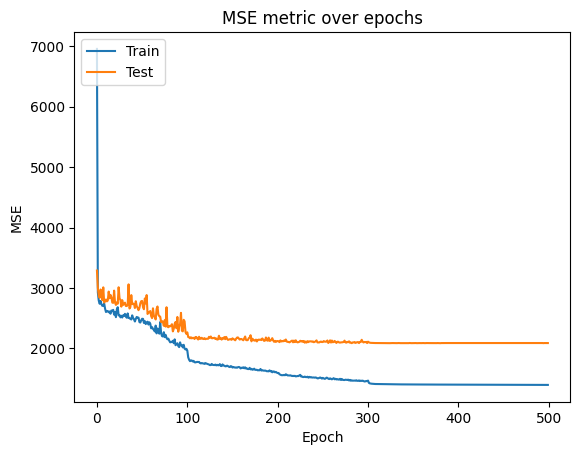

In [87]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE metric over epochs')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

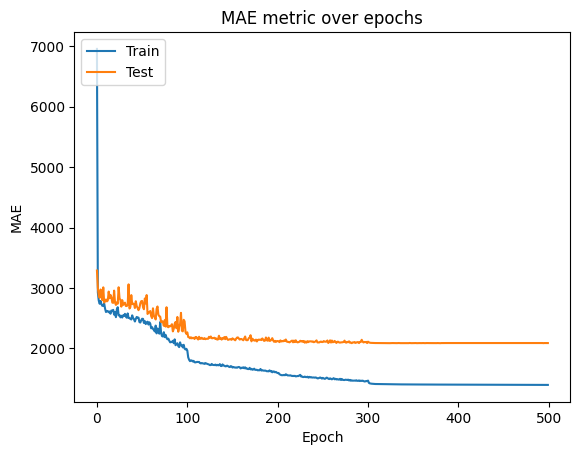

In [88]:
import matplotlib.pyplot as plt

plt.plot(history.history[m2])
plt.plot(history.history['val_'+m2])
plt.title('MAE metric over epochs')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Evaluation by `evaluate()` method

1. Evaluate model through 



In [89]:
# ==================================================================
# SPLIT VALIDATION DATA INTO FEATURES AND TARGET
# ==================================================================
# X_val = df_val[ALL_FEATURES_TRANSFORMED_BUT_TARGET].to_numpy()
# y_val = df_val[TARGET].to_numpy()
# ==================================================================
# USE VALIDATION DATA TO EVALUATE MODEL
# ==================================================================
score = model.evaluate(X_val, y_val,  verbose=1)
print(f'\n\nMODEL EVALUATION')
print(f'================')
print(f'Loss: {round(score[0], 2)}')
print(f'---------------------------------------------------------')
print(f'Metric: {round(score[1], 2)}')
print(f'---------------------------------------------------------')
rmse = pow(abs(score[0]), 0.5)
print(f'RMSE: {round(rmse, 4)}')
print(f'---------------------------------------------------------')
y_norm = y_val.max() - y_val.min()
rmse = pow(abs(score[0]), 0.5)
nrmse = rmse / y_norm
print(f'NRMSE: {round(nrmse, 4)}')
print(f'---------------------------------------------------------')
Q1 = df_val[TARGET].quantile(0.25)
Q3 = df_val[TARGET].quantile(0.75)
IQR = Q3 - Q1
rmseiqr = rmse / IQR
print(f'RMSEIQR: {round(rmseiqr, 4)}')
print(f'---------------------------------------------------------')
acc = round(score[1], 0)

75/75 [==============================] - 0s 1ms/step - loss: 2016.3348 - mean_absolute_error: 2016.3348


MODEL EVALUATION
Loss: 2016.33
---------------------------------------------------------
Metric: 2016.33
---------------------------------------------------------
RMSE: 44.9036
---------------------------------------------------------
NRMSE: 0.0007
---------------------------------------------------------
RMSEIQR: 0.0044
---------------------------------------------------------


## Predictions

1. Get prediction data

1. Compute model accuracy with prediction data

1. Print predictions results

In [90]:
# ==================================================================
# MAKE PREDICTIONS 
# ==================================================================
# Using same parameters as production model
y_pred = model.predict(
    X_val,
    batch_size = batch_size,
    verbose='auto',
    steps = None,
    callbacks = [lr_scheduler],
    max_queue_size = 10,
    workers = 1,
    use_multiprocessing = False
)
# ==================================================================
# DISPLAYING PREDICTIONS
# ==================================================================
X_pred_scaled = df_pred[ALL_FEATURES_BUT_TARGET].to_numpy()
y_pred_val = model.predict(X_pred_scaled)
print('Predicted price first item: %.2f' % y_pred_val[0][0])
print('Predicted price second item: %.2f' % y_pred_val[1][0])
print('Predicted price third item: %.2f' % y_pred_val[2][0])
print('Predicted price fourth item: %.2f' % y_pred_val[3][0])
print('Predicted price fifth item: %.2f' % y_pred_val[4][0])

1/1 [==============================] - 0s 20ms/step
Predicted price first item: 8859.65
Predicted price second item: 18130.30
Predicted price third item: 35671.30
Predicted price fourth item: 23063.67
Predicted price fifth item: 20945.10


In [91]:
df_cleaned.loc[index_list, :]

,color,fuelType,km,make,model,province,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp,price
580,black,diesel,126000.0,renault,megane,cordoba,manual,2012,profesional,sedan,1461.0,5,110.0,7999.0
6132,black,gasolina,24000.0,kia,ceed_tourer,sta_c_tenerife,manual,2020,profesional,familiar,998.0,5,120.0,14990.0
3612,black,diesel,33000.0,mercedes_benz,clase_b,toledo,automatic,2021,profesional,minivan,1950.0,5,150.0,33700.0
3513,gray,diesel,71430.0,mercedes_benz,clase_cla,jaen,automatic,2015,profesional,sedan,2143.0,4,136.0,22990.0
9384,red,diesel,88785.0,audi,a3,alicante,automatic,2018,profesional,berlina,1598.0,4,116.0,21790.0


## Evaluation by Keras Regression Metrics

> * [MeanRelativeError](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanRelativeError)

> * [Keras Regression Metrics](https://keras.io/api/metrics/regression_metrics)

In [92]:
input = 'mae'
output = computeRegressionMetric(y_pred, y_val, input)
print(f'Metric: {input} - {output}')
input = 'mape'
output = computeRegressionMetric(y_pred, y_val, input)
print(f'Metric: {input} - {output}')
input = 'mse'
output = computeRegressionMetric(y_pred, y_val, input)
print(f'Metric: {input} - {output}')
input = 'rmse'
output = computeRegressionMetric(y_pred, y_val, input)
print(f'Metric: {input} - {output}')
# input = 'mre'
# output = computeRegressionMetric(y_pred, y_val, input)
# print(f'Metric: {input} - {output}')

Metric: mae - 2016.334716796875
Metric: mape - 10.397618293762207
Metric: mse - 8548906.0
Metric: rmse - 2923.851318359375


# SAVE DATA TO FILE



## Save model to file

In [93]:
from tensorflow import keras
import pickle
from datetime import datetime
import pytz
from os.path import realpath

# ==================================================================
# APPEND MODEL ACCURACY TO FILE NAME
# ==================================================================
ACC = str(int(round(acc, 0))) + '-MAE-'
# ==================================================================
# APPEND CURRENT DATE-TIME INFO. TO FILE NAME
# ==================================================================
tz = pytz.timezone("Europe/Madrid")
now = datetime.now(tz)
formatted_date = now.strftime("%d-%m-%Y-%H-%M")
# ==================================================================
# SETTING FILE PATH AND NAME
# ==================================================================
SUFFIX = '.h5'
BASE = 'C:/Python/project-flask/Files/'
FILENAME = 'cochesnet-model-' + ACC + formatted_date 
PATH = BASE + FILENAME + SUFFIX
# ==================================================================
# SAVE MODEL DATA WITH KERAS .SAVE()
# ==================================================================
try:
    model.save(realpath(PATH))
except NameError as NE:
    (print(f"ERROR!!: <{NE}>' in file: <{PATH}>"))
except FileNotFoundError as FNF:
    raise Exception("ERROR!! File not found: {FNF}")
except:
    raise Exception("Unknown error")
else:
    print(f"Data <{PATH}> saved successfully")
finally:
    print("Program finalized")

Data <C:/Python/project-flask/Files/cochesnet-model-2016-MAE-03-05-2023-10-21.h5> saved successfully
Program finalized


## Save project data to file

In [94]:
from tensorflow import keras
import pickle
from datetime import datetime
import pytz
from os.path import realpath

# -------------------------------------------------------------------
tz = pytz.timezone("Europe/Madrid")
now = datetime.now(tz)
formatted_date = now.strftime("%d-%m-%Y-%H-%M")
# -------------------------------------------------------------------
BASE = 'C:/Python/project-flask/Files/'
SUFFIX1 = '.pkl'
SUFFIX2 = '.csv'
# FILENAME = 'preprocess_50K_' + formatted_date 
FILENAME = 'cochesnet-data-' + formatted_date 
PATH1 = BASE + FILENAME + SUFFIX1
# -------------------------------------------------------------------
with open(realpath(PATH), 'wb') as f:
    pickle.dump([
        df_train, 
        df_val,
        df_pred, 
        df_cleaned,
        df_cleaned_transformed,
        df_cleaned_transformed_scaled,
        index_list,
        scaler,
        encoder
    ], f)
    # Save post-processed dataframe into CSV file
    PATH2 = BASE + FILENAME + SUFFIX2
    df_cleaned.to_csv(PATH2)
    print(f"Data <{PATH1}> saved successfully")
    f.close() # Check if file was closed properly  

Data <C:/Python/project-flask/Files/cochesnet-data-03-05-2023-10-21.pkl> saved successfully




---



---

# Warehouse

---



---



## Save model history

In [ ]:
from tensorflow import keras
import pickle
from datetime import datetime
import pytz
BASE = 'C:/Python/project-flask/Files/'
# ==================================================================
# APPEND MODEL ACCURACY TO FILE NAME
# ==================================================================
ACC = str(int(round(acc, 0))) + '-MAE-'
# ==================================================================
# APPEND CURRENT DATE-TIME INFO. TO FILE NAME
# ==================================================================
tz = pytz.timezone("Europe/Madrid")
now = datetime.now(tz)
formatted_date = now.strftime("%d-%m-%Y-%H-%M")
# ==================================================================
# SETTING FILE PATH AND NAME
# ==================================================================
SUFFIX = '.pkl'
FILENAME = 'final-model-history-' + ACC + formatted_date 
PATH = BASE + FILENAME + SUFFIX
# ==================================================================
# SERIALIZE MODEL HISTORY AND WRITE IT INTO FILE
# ==================================================================
with open(PATH, 'wb') as f:
    pickle.dump([
        history.history,
    ], f)
# Check if file is already closed    
f.close()


In [ ]:
from keras.metrics import MeanSquaredError
metric = MeanSquaredError()
metric.update_state(y_pred, y_val)
outcome = metric.result().numpy()
outcome = round(outcome, 6)
print('Mean Squared Error: %.2f' % outcome)
# -----------------------------------

In [ ]:
from keras.metrics import RootMeanSquaredError

metric = RootMeanSquaredError()
metric.update_state(y_pred, y_val)
outcome = metric.result().numpy()
outcome = round(outcome, 6)
print('Root Mean Squared Error: %.2f' % outcome)

In [ ]:
from keras.metrics import MeanRelativeError

metric = MeanRelativeError(normalizer = y_pred)
metric.update_state(y_pred, y_val)
outcome = metric.result().numpy()
outcome = round(outcome, 6)
print('Mean Relative Error: %.2f' % outcome)

In [ ]:
from keras.metrics import MeanAbsoluteError

metric = MeanAbsoluteError()
metric.update_state(y_pred, y_val)
outcome = metric.result().numpy()
outcome = round(outcome, 6)
print('Mean Absolute Error: %.2f' % outcome)

In [ ]:
from keras.metrics import MeanAbsolutePercentageError

metric = MeanAbsolutePercentageError()
metric.update_state(y_pred, y_val)
outcome = metric.result().numpy()
outcome = round(outcome, 6)
print('Mean Absolute Percentage Error: %.2f' % outcome)

In [ ]:
# DataFrame queries
df_temp.query("@feature in ['yellow', 'purple']").index.size

df_temp.query(f"{feature_name} in ['coupe', 'pick_up', 'cabrio']").index.to_list()

In [ ]:
# Object memory size
import sys

sys.getsizeof(df_temp)

In [ ]:
# Setting the columns to keep in dataset
columns_to_keep = set(df.columns.values)
columns_to_keep.difference_update(set(columns_to_drop))
print(columns_to_keep)

In [ ]:
# Cast data specifically
df_out = df_out.astype({
    'km':np.uint64,
    'cubicCapacity':np.uint64,
    'doors':np.uint8,
    'hp':np.uint16,
    'price':np.uint64,
    'year':np.uint16
})

In [ ]:
# Getting all the non-numeric features (categorical features)
CATEGORICAL_FEATURES = df_out.select_dtypes(exclude=[np.number]).columns.to_list()
# Getting all the numeric features
NUMERIC_FEATURES = df_out.select_dtypes(include=[np.number]).columns.to_list()



---



---

## Testing area

---



---



In [ ]:
    print(f'---------------------------------------------------------')
    # Print Interquartile Rooted Mean Squared Error
    Q1 = y_test.quantile(0.25)
    Q3 = y_test.quantile(0.75)
    IQR = Q3 - Q1
    rmseiqr = rmse / IQR
    print(f'RMSEIQR: {round(rmseiqr, 4)}')



---



---



---



---

TEST A

In [ ]:
df_train.info()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# X = df_train[ALL_FEATURES_TRANSFORMED_BUT_TARGET].to_numpy()
# y = df_train[TARGET].to_numpy()
X = df_train[ALL_FEATURES_TRANSFORMED_BUT_TARGET].to_numpy()
y = df_train[TARGET].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, shuffle=True, random_state = None)

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'Datos entrenamiento: {model.score(X_train, y_train)}')
print(f'Datos de prueba: {model.score(X_test, y_test)}')
# print(model.score(X_val, y_val))

print ("Coeff and intercept:", model.coef_ , model.intercept_)



---



---



---



---





---



---



---



---

TEST B

In [ ]:
!pip install scikeras

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import r2_score

# Entrenar el modelo
model = baseline_model()

X = df_train[ALL_FEATURES_TRANSFORMED_BUT_TARGET].to_numpy()
y = df_train[TARGET].to_numpy()

# define the keras model
estimator = KerasRegressor(
    model = model,
    epochs = epochs,
    batch_size = batch_size,
    verbose = 1
)

kfold = KFold(n_splits = partitions)
history = cross_val_score(
    estimator,
    X,
    y,
    cv = kfold,
    # scoring = 'neg_mean_squared_error'
    scoring = 'r2'
)

In [ ]:
print(f'---------------------------------------------------------')
print("Negative Mean Squared Error: %.2f (scaled data)" % (history.mean()))
print("Standar Deviation: %.2f (scaled data)" % history.std())
print(f'---------------------------------------------------------')



---



---



---



---

TEST C

In [ ]:
from sklearn.model_selection import train_test_split

# Entrenar el modelo
model = baseline_model()

X = df_train[ALL_FEATURES_TRANSFORMED_BUT_TARGET].to_numpy()
y = df_train[TARGET].to_numpy()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size = 0.25, random_state = None)

history = model.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    epochs = 1000,
    batch_size = 32,
    verbose = 'auto',
    callbacks=[lr_scheduler]
)

loss = mean(history.history['loss'])
print(f'LOSS: {loss}')
print(f'---------------------------------------------------------')
mse = mean(history.history['mse'])
print(f'MSE: {mse}')
print(f'---------------------------------------------------------')
mae = mean(history.history['mae'])
print(f'MAE: {mae}')
print(f'---------------------------------------------------------')
rmse = pow(abs(mse), 0.5)
print(f'Rooted MSE: {round(rmse, 4)}') 



---



---



---



---

